In [1]:
import sys
tmp_path = []
for it in sys.path:
    if not 'gym' in it:
        # print(it)
        tmp_path.append(it)
sys.path = tmp_path
sys.path.append('../..')

In [2]:
from __future__ import print_function
import copy
import os
import numpy as np
import six.moves.cPickle as pickle

import gym
from PIL import Image

import chainer
from chainer import cuda, FunctionSet, Variable, optimizers
import chainer.functions as F
from chainer.links import caffe

%matplotlib inline
import matplotlib.pyplot as plt

# CnnDqnAgent

In [3]:
class CnnDqnAgent(object):
    policy_frozen = False
    epsilon_delta = 1.0 / 10 ** 4.4
    min_eps = 0.1

    actions = [0, 1, 2]

    cnn_feature_extractor = 'alexnet_feature_extractor.pickle'
    model = 'bvlc_alexnet.caffemodel'
    model_type = 'alexnet'
    image_feature_dim = 256 * 6 * 6
    image_feature_count = 1

    def _observation_to_featurevec(self, observation):
        # TODO clean
        if self.image_feature_count == 1:
            return np.r_[self.feature_extractor.feature(observation["image"][0]),
                         observation["depth"][0]]

        else:
            print("not supported: number of camera")

    def agent_init(self, **options):
        self.use_gpu = options['use_gpu']
        self.depth_image_dim = options['depth_image_dim']
        self.q_net_input_dim = self.image_feature_dim * self.image_feature_count + self.depth_image_dim

        if os.path.exists(self.cnn_feature_extractor):
            print("loading... " + self.cnn_feature_extractor)
            self.feature_extractor = pickle.load(open(self.cnn_feature_extractor))
            print("done")
        else:
            self.feature_extractor = CnnFeatureExtractor(self.use_gpu, self.model, self.model_type, self.image_feature_dim)
            pickle.dump(self.feature_extractor, open(self.cnn_feature_extractor, 'wb'),-1)
            print("pickle.dump finished")

        self.time = 0
        self.epsilon = 1.0  # Initial exploratoin rate
        self.q_net = QNet(self.use_gpu, self.actions, self.q_net_input_dim)

    def agent_start(self, observation):
        obs_array = self._observation_to_featurevec(observation)

        # Initialize State
        self.state = np.zeros((self.q_net.hist_size, self.q_net_input_dim), dtype=np.uint8)
        self.state[0] = obs_array
        state_ = np.asanyarray(self.state.reshape(1, self.q_net.hist_size, self.q_net_input_dim), dtype=np.float32)
        if self.use_gpu >= 0:
            state_ = cuda.to_gpu(state_)

        # Generate an Action e-greedy
        action, q_now = self.q_net.e_greedy(state_, self.epsilon)
        return_action = action

        # Update for next step
        self.last_action = copy.deepcopy(return_action)
        self.last_state = self.state.copy()
        self.last_observation = obs_array

        return return_action

    def agent_step(self, reward, observation):
        obs_array = self._observation_to_featurevec(observation)

        # Compose State : 4-step sequential observation
        if self.q_net.hist_size == 4:
            self.state = np.asanyarray([self.state[1], self.state[2], self.state[3], obs_array], dtype=np.uint8)
        elif self.q_net.hist_size == 2:
            self.state = np.asanyarray([self.state[1], obs_array], dtype=np.uint8)
        elif self.q_net.hist_size == 1:
            self.state = np.asanyarray([obs_array], dtype=np.uint8)
        else:
            print("self.DQN.hist_size err")

        state_ = np.asanyarray(self.state.reshape(1, self.q_net.hist_size, self.q_net_input_dim), dtype=np.float32)
        if self.use_gpu >= 0:
            state_ = cuda.to_gpu(state_)

        # Exploration decays along the time sequence
        if self.policy_frozen is False:  # Learning ON/OFF
            if self.q_net.initial_exploration < self.time:
                self.epsilon -= self.epsilon_delta
                if self.epsilon < self.min_eps:
                    self.epsilon = self.min_eps
                eps = self.epsilon
            else:  # Initial Exploation Phase
                print("Initial Exploration : %d/%d steps" % (self.time, self.q_net.initial_exploration)),
                eps = 1.0
        else:  # Evaluation
            print("Policy is Frozen")
            eps = 0.05

        # Generate an Action by e-greedy action selection
        action, q_now = self.q_net.e_greedy(state_, eps)

        return action, eps, q_now, obs_array

    def agent_step_update(self, reward, action, eps, q_now, obs_array):
        # Learning Phase
        if self.policy_frozen is False:  # Learning ON/OFF
            self.q_net.stock_experience(self.time, self.last_state, self.last_action, reward, self.state, False)
            self.q_net.experience_replay(self.time)

        # Target model update
        if self.q_net.initial_exploration < self.time and np.mod(self.time, self.q_net.target_model_update_freq) == 0:
            print("Model Updated")
            self.q_net.target_model_update()

        # Simple text based visualization
        if self.use_gpu >= 0:
            q_max = np.max(q_now.get())
        else:
            q_max = np.max(q_now)

        print('Step:%d  Action:%d  Reward:%.1f  Epsilon:%.6f  Q_max:%3f' % (
            self.time, self.q_net.action_to_index(action), reward, eps, q_max))

        # Updates for next step
        self.last_observation = obs_array

        if self.policy_frozen is False:
            self.last_action = copy.deepcopy(action)
            self.last_state = self.state.copy()
            self.time += 1

    def agent_end(self, reward):  # Episode Terminated
        print('episode finished. Reward:%.1f / Epsilon:%.6f' % (reward, self.epsilon))

        # Learning Phase
        if self.policy_frozen is False:  # Learning ON/OFF
            self.q_net.stock_experience(self.time, self.last_state, self.last_action, reward, self.last_state,
                                        True)
            self.q_net.experience_replay(self.time)

        # Target model update
        if self.q_net.initial_exploration < self.time and np.mod(self.time, self.q_net.target_model_update_freq) == 0:
            print("Model Updated")
            self.q_net.target_model_update()

        # Time count
        if self.policy_frozen is False:
            self.time += 1


# CnnFeatureExtractor

In [4]:
class CnnFeatureExtractor:
    def __init__(self, gpu, model, model_type, out_dim):
        self.gpu = gpu
        self.model = 'bvlc_alexnet.caffemodel'
        self.model_type = 'alexnet'
        self.batchsize = 1
        self.out_dim = out_dim

        if self.gpu >= 0:
            cuda.check_cuda_available()

        print('Loading Caffe model file %s...' % self.model, file = sys.stderr)
        self.func = caffe.CaffeFunction(self.model)
        print('Loaded', file=sys.stderr)
        if self.gpu >= 0:
            cuda.get_device(self.gpu).use()
            self.func.to_gpu()

        if self.model_type == 'alexnet':
            self.in_size = 227
            mean_image = np.load('ilsvrc_2012_mean.npy')
            del self.func.layers[15:23]
            self.outname = 'pool5'
            #del self.func.layers[13:23]
            #self.outname = 'conv5'

            
        cropwidth = 256 - self.in_size
        start = cropwidth // 2
        stop = start + self.in_size
        self.mean_image = mean_image[:, start:stop, start:stop].copy()
                
    def predict(self, x):
        y, = self.func(inputs={'data': x}, outputs=[self.outname], train=False)
        return y

    def feature(self, camera_image):
        x_batch = np.ndarray((self.batchsize, 3, self.in_size, self.in_size), dtype=np.float32)
        image = np.asarray(camera_image).transpose(2, 0, 1)[::-1].astype(np.float32)
        image -= self.mean_image

        x_batch[0] = image
        xp = cuda.cupy if self.gpu >= 0 else np
        x_data = xp.asarray(x_batch)

        if self.gpu >= 0:
            x_data=cuda.to_gpu(x_data)
        
        x = chainer.Variable(x_data, volatile=True)
        feature = self.predict(x)

        if self.gpu >= 0:
            feature = cuda.to_cpu(feature.data)
            feature = feature.reshape(self.out_dim)
        else:
            feature = feature.data.reshape(self.out_dim)

        return feature * 255.0


# QNet

In [5]:
class QNet:
    # Hyper-Parameters
    gamma = 0.99  # Discount factor
    initial_exploration = 10**3  # Initial exploratoin. original: 5x10^4
    replay_size = 32  # Replay (batch) size
    target_model_update_freq = 10**4  # Target update frequancy. original: 10^4
    data_size = 10**5  # Data size of history. original: 10^6
    hist_size = 1 #original: 4

    def __init__(self, use_gpu, enable_controller, dim):
        self.use_gpu = use_gpu
        self.num_of_actions = len(enable_controller)
        self.enable_controller = enable_controller
        self.dim = dim

        print("Initializing Q-Network...")

        hidden_dim = 256
        self.model = FunctionSet(
            l4=F.Linear(self.dim*self.hist_size, hidden_dim, wscale=np.sqrt(2)),
            q_value=F.Linear(hidden_dim, self.num_of_actions,
                             initialW=np.zeros((self.num_of_actions, hidden_dim),
                                               dtype=np.float32))
        )
        if self.use_gpu >= 0:
            self.model.to_gpu()

        self.model_target = copy.deepcopy(self.model)

        self.optimizer = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
        self.optimizer.setup(self.model.collect_parameters())

        # History Data :  D=[s, a, r, s_dash, end_episode_flag]
        self.d = [np.zeros((self.data_size, self.hist_size, self.dim), dtype=np.uint8),
                  np.zeros(self.data_size, dtype=np.uint8),
                  np.zeros((self.data_size, 1), dtype=np.int8),
                  np.zeros((self.data_size, self.hist_size, self.dim), dtype=np.uint8),
                  np.zeros((self.data_size, 1), dtype=np.bool)]

    def forward(self, state, action, reward, state_dash, episode_end):
        num_of_batch = state.shape[0]
        s = Variable(state)
        s_dash = Variable(state_dash)

        q = self.q_func(s)  # Get Q-value

        # Generate Target Signals
        tmp = self.q_func_target(s_dash)  # Q(s',*)
        if self.use_gpu >= 0:
            tmp = list(map(np.max, tmp.data.get()))  # max_a Q(s',a)
        else:
            tmp = list(map(np.max, tmp.data))  # max_a Q(s',a)

        max_q_dash = np.asanyarray(tmp, dtype=np.float32)
        if self.use_gpu >= 0:
            target = np.asanyarray(q.data.get(), dtype=np.float32)
        else:
            # make new array
            target = np.array(q.data, dtype=np.float32)

        for i in xrange(num_of_batch):
            if not episode_end[i][0]:
                tmp_ = reward[i] + self.gamma * max_q_dash[i]
            else:
                tmp_ = reward[i]

            action_index = self.action_to_index(action[i])
            target[i, action_index] = tmp_

        # TD-error clipping
        if self.use_gpu >= 0:
            target = cuda.to_gpu(target)
        td = Variable(target) - q  # TD error
        td_tmp = td.data + 1000.0 * (abs(td.data) <= 1)  # Avoid zero division
        td_clip = td * (abs(td.data) <= 1) + td/abs(td_tmp) * (abs(td.data) > 1)

        zero_val = np.zeros((self.replay_size, self.num_of_actions), dtype=np.float32)
        if self.use_gpu >= 0:
            zero_val = cuda.to_gpu(zero_val)
        zero_val = Variable(zero_val)
        loss = F.mean_squared_error(td_clip, zero_val)
        return loss, q

    def stock_experience(self, time,
                        state, action, reward, state_dash,
                        episode_end_flag):
        data_index = time % self.data_size

        if episode_end_flag is True:
            self.d[0][data_index] = state
            self.d[1][data_index] = action
            self.d[2][data_index] = reward
        else:
            self.d[0][data_index] = state
            self.d[1][data_index] = action
            self.d[2][data_index] = reward
            self.d[3][data_index] = state_dash
        self.d[4][data_index] = episode_end_flag

    def experience_replay(self, time):
        if self.initial_exploration < time:
            # Pick up replay_size number of samples from the Data
            if time < self.data_size:  # during the first sweep of the History Data
                replay_index = np.random.randint(0, time, (self.replay_size, 1))
            else:
                replay_index = np.random.randint(0, self.data_size, (self.replay_size, 1))

            s_replay = np.ndarray(shape=(self.replay_size, self.hist_size, self.dim), dtype=np.float32)
            a_replay = np.ndarray(shape=(self.replay_size, 1), dtype=np.uint8)
            r_replay = np.ndarray(shape=(self.replay_size, 1), dtype=np.float32)
            s_dash_replay = np.ndarray(shape=(self.replay_size, self.hist_size, self.dim), dtype=np.float32)
            episode_end_replay = np.ndarray(shape=(self.replay_size, 1), dtype=np.bool)
            for i in xrange(self.replay_size):
                s_replay[i] = np.asarray(self.d[0][replay_index[i]], dtype=np.float32)
                a_replay[i] = self.d[1][replay_index[i]]
                r_replay[i] = self.d[2][replay_index[i]]
                s_dash_replay[i] = np.array(self.d[3][replay_index[i]], dtype=np.float32)
                episode_end_replay[i] = self.d[4][replay_index[i]]

            if self.use_gpu >= 0:
                s_replay = cuda.to_gpu(s_replay)
                s_dash_replay = cuda.to_gpu(s_dash_replay)

            # Gradient-based update
            self.optimizer.zero_grads()
            loss, _ = self.forward(s_replay, a_replay, r_replay, s_dash_replay, episode_end_replay)
            loss.backward()
            self.optimizer.update()

    def q_func(self, state):
        h4 = F.relu(self.model.l4(state / 255.0))
        q = self.model.q_value(h4)
        return q

    def q_func_target(self, state):
        h4 = F.relu(self.model_target.l4(state / 255.0))
        q = self.model_target.q_value(h4)
        return q

    def e_greedy(self, state, epsilon):
        s = Variable(state)
        q = self.q_func(s)
        q = q.data

        if np.random.rand() < epsilon:
            index_action = np.random.randint(0, self.num_of_actions)
            print(" Random"),
        else:
            if self.use_gpu >= 0:
                index_action = np.argmax(q.get())
            else:
                index_action = np.argmax(q)
            print("#Greedy"),
        return self.index_to_action(index_action), q

    def target_model_update(self):
        self.model_target = copy.deepcopy(self.model)

    def index_to_action(self, index_of_action):
        return self.enable_controller[index_of_action]

    def action_to_index(self, action):
        return self.enable_controller.index(action)


# Lis_DQN

In [6]:
agent = CnnDqnAgent()
agent_initialized = False

cycle_counter = 0
log_file = 'reward.log'
reward_sum = 0
depth_image_dim = 32 * 32
depth_image_count = 1
total_episode = 10000
episode_count = 1
gpu = 0  # gpu id (-1 to use cpu)

In [7]:
while episode_count <= total_episode:
    if not agent_initialized:
        agent_initialized = True
        print ("initializing agent...")
        agent.agent_init(
            use_gpu=gpu,
            depth_image_dim=depth_image_dim * depth_image_count)

        env = gym.make('Lis-v2')

        observation = env.reset()  
        action = agent.agent_start(observation) 
        observation, reward, end_episode, _ = env.step(action)  

        with open(log_file, 'w') as the_file:
            the_file.write('cycle, episode_reward_sum \n')
    else:
        cycle_counter += 1  
        reward_sum += reward

        if end_episode:
            agent.agent_end(reward)

            
            action = agent.agent_start(observation)  # TODO
            observation, reward, end_episode, _ = env.step(action)

            with open(log_file, 'a') as the_file:
                the_file.write(str(cycle_counter) +
                               ',' + str(reward_sum) + '\n')
            reward_sum = 0
            episode_count += 1

        else:
            action, eps, q_now, obs_array = agent.agent_step(reward, observation)  
            agent.agent_step_update(reward, action, eps, q_now, obs_array)
            observation, reward, end_episode, _ = env.step(action)  

env.close()


initializing agent...
loading... alexnet_feature_extractor.pickle


/usr/local/lib/python2.7/dist-packages/chainer/function_set.py:62: FutureWarning: 'collect_parameters' is deprecated. You can pass FunctionSet itself to 'optimizer.setup'
  warnings.warn(msg, FutureWarning)
[2017-01-18 16:42:06,378] Making new env: Lis-v2
--- request header ---
[2017-01-18 16:42:06,383] --- request header ---
GET /CommunicationGym HTTP/1.1
Upgrade: websocket
Connection: Upgrade
Host: localhost:4649
Origin: http://localhost:4649
Sec-WebSocket-Key: mmRXLWMUDH4jDYYTd0M2Ug==
Sec-WebSocket-Version: 13


[2017-01-18 16:42:06,384] GET /CommunicationGym HTTP/1.1
Upgrade: websocket
Connection: Upgrade
Host: localhost:4649
Origin: http://localhost:4649
Sec-WebSocket-Key: mmRXLWMUDH4jDYYTd0M2Ug==
Sec-WebSocket-Version: 13


-----------------------
[2017-01-18 16:42:06,385] -----------------------
--- response header ---
[2017-01-18 16:42:06,386] --- response header ---
HTTP/1.1 101 Switching Protocols
[2017-01-18 16:42:06,399] HTTP/1.1 101 Switching Protocols
Server: websocket-sh

done
Initializing Q-Network...


send: '\x81\x8b\xe9\xbfY\x19h\x18:v\x84\xd28w\x8d\x1ei'
[2017-01-18 16:42:06,748] send: '\x81\x8b\xe9\xbfY\x19h\x18:v\x84\xd28w\x8d\x1ei'
send: '\x81\x8b\xe1\xdf\xdf\x1d`x\xbcr\x8c\xb2\xbes\x85~\xed'
[2017-01-18 16:42:06,787] send: '\x81\x8b\xe1\xdf\xdf\x1d`x\xbcr\x8c\xb2\xbes\x85~\xed'


 Random
Initial Exploration : 0/1000 steps
 Random
Step:0  Action:2  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8b\x83\xfa\x1d/\x02]~@\xee\x97|A\xe7[-'
[2017-01-18 16:42:07,039] send: '\x81\x8b\x83\xfa\x1d/\x02]~@\xee\x97|A\xe7[-'


Initial Exploration : 1/1000 steps
 Random
Step:1  Action:0  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8b\xa8f\xb6\xd9)\xc1\xd5\xb6\xc5\x0b\xd7\xb7\xcc\xc7\x87'
[2017-01-18 16:42:07,250] send: '\x81\x8b\xa8f\xb6\xd9)\xc1\xd5\xb6\xc5\x0b\xd7\xb7\xcc\xc7\x87'


Initial Exploration : 2/1000 steps
 Random
Step:2  Action:1  Reward:0.0  Epsilon:1.000000  Q_max:0.000000
Initial Exploration : 3/1000 steps

send: '\x81\x8b*\xe3\x14%\xabDwJG\x8euKNB&'
[2017-01-18 16:42:07,450] send: '\x81\x8b*\xe3\x14%\xabDwJG\x8euKNB&'



 Random
Step:3  Action:2  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8b\xf4\xe8|{uO\x1f\x14\x99\x85\x1d\x15\x90IL'
[2017-01-18 16:42:07,666] send: '\x81\x8b\xf4\xe8|{uO\x1f\x14\x99\x85\x1d\x15\x90IL'


Initial Exploration : 4/1000 steps
 Random
Step:4  Action:0  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8b\x88%|@\t\x82\x1f/\xe5H\x1d.\xec\x84M'
[2017-01-18 16:42:07,913] send: '\x81\x8b\x88%|@\t\x82\x1f/\xe5H\x1d.\xec\x84M'


Initial Exploration : 5/1000 steps
 Random
Step:5  Action:1  Reward:1.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8bP\x13\xb9\x15\xd1\xb4\xdaz=~\xd8{4\xb2\x8b'
[2017-01-18 16:42:08,117] send: '\x81\x8bP\x13\xb9\x15\xd1\xb4\xdaz=~\xd8{4\xb2\x8b'
send: '\x81\x8b&\xeb\x14S\xa7Lw<K\x86u=BJ&'
[2017-01-18 16:42:08,265] send: '\x81\x8b&\xeb\x14S\xa7Lw<K\x86u=BJ&'


Initial Exploration : 6/1000 steps
 Random
Step:6  Action:2  Reward:0.0  Epsilon:1.000000  Q_max:0.000000
Initial Exploration : 7/1000 steps
 Random
Step:7  Action:2  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x81\x8bu\x9d*\x8b\xf4:I\xe4\x18\xf0K\xe5\x11<\x1b'
[2017-01-18 16:42:08,513] send: '\x81\x8bu\x9d*\x8b\xf4:I\xe4\x18\xf0K\xe5\x11<\x1b'


Initial Exploration : 8/1000 steps
 Random
Step:8  Action:1  Reward:0.0  Epsilon:1.000000  Q_max:0.000000


send: '\x88\x82+#\xc9\x88(\xcb'
[2017-01-18 16:42:08,737] send: '\x88\x82+#\xc9\x88(\xcb'


WebSocketConnectionClosedException: Connection is already closed.

# Show observation image

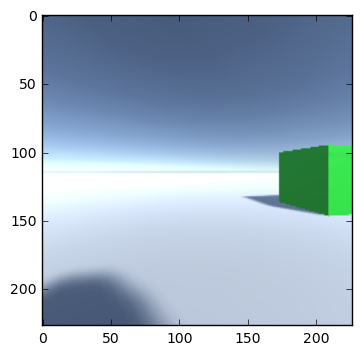

In [8]:
plt.imshow(np.array(observation['image'][0]))

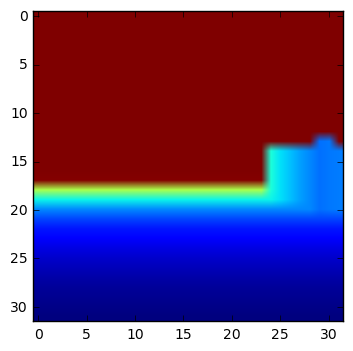

In [9]:
plt.imshow(observation['depth'][0].reshape(32,32))